In [18]:
import pingouin as pg
import pandas as pd
import numpy as np
import scipy.io
from matplotlib import pyplot as plt
import seaborn
import math
#from statsmodels.stats.diagnostic import acorr_breusch_godfrey

from os import listdir
from os.path import dirname, join


#### Construct a dictionary that maps subject ID number (as in the raw .mat filename) to row numbers in the 3D array original_ts and fitted_ts. We use this to make sure that the same row of original_ts and fitted_ts correpond to the same subject.

In [19]:
file_dir = 'E:/projects/connectome/data/FMRI_820subjects'
file_names = listdir(file_dir)

ID_to_row_num = {}
for row_num,file_name in enumerate(file_names):
    ID_num = file_name[-10:-4]
    subject_ID = 'sub'+ID_num
    ID_to_row_num[subject_ID] = row_num                        

#### Now load data

In [20]:
# Load original time series
original_ts = [None for _ in range(len(file_names))] # original_ts[i][j] stores the time series of region j of subject i 
file_dir = 'E:/projects/connectome/data/FMRI_820subjects'
file_names = listdir(file_dir)

for file_name in file_names:
    ID_num = file_name[-10:-4]
    subject_ID = 'sub'+ID_num
    
    file = join(file_dir,file_name)
    file_mat = scipy.io.loadmat(file)
    
    original_ts[ID_to_row_num[subject_ID]]=file_mat['tc']

    
print("Total number of files loaded: "+str(len(original_ts)))

Total number of files loaded: 820


In [21]:
# Load ensemble both of the fitted ensemble for (p,q) from 0-4
fitted_ts1 = [None for _ in range(len(file_names))]
file_dir = 'E:/projects/connectome/results/HurstExp_ARMA_results_0_to_4/ensemble_ts'
file_names = listdir(file_dir)

for file_name in file_names:
    ID_num = file_name[-10:-4]
    subject_ID = 'sub'+ID_num
    
    file = join(file_dir,file_name)
    file_mat = scipy.io.loadmat(file)
    
    fitted_ts1[ID_to_row_num[subject_ID]]=file_mat['ensemble_ts']

    
print("Total number of files loaded: "+str(len(fitted_ts1)))


# Load ensemble fitted ensemble for (p,q) from 0-5
fitted_ts2 = [None for _ in range(len(file_names))]
file_dir = 'E:/projects/connectome/results/HurstExp_ARMA_results_0_to_5/ensemble_ts'
file_names = listdir(file_dir)

for file_name in file_names:
    ID_num = file_name[-10:-4]
    subject_ID = 'sub'+ID_num
    
    file = join(file_dir,file_name)
    file_mat = scipy.io.loadmat(file)
    
    fitted_ts2[ID_to_row_num[subject_ID]]=file_mat['ensemble_ts']

    
print("Total number of files loaded: "+str(len(fitted_ts2)))

Total number of files loaded: 820
Total number of files loaded: 820


# Plotting the Ensemble Time-series on top of the Original

In [22]:
def plotTS(original_ts,sub,reg,start=0,end=100,fitted_ts1=None,fitted_ts2=None):
    # sub: subject ID, an 6-digit number, data type:int
    # reg: region number, data type: int
    # start, end: starting point and end point of the time-series that is to be plotted, data type:int
    fitted1 = fitted2 = None
    if fitted_ts1:
        fitted1 = fitted_ts1[ID_to_row_num['sub'+str(sub)]][reg,:][start:end]
    if fitted_ts2:
        fitted2 = fitted_ts2[ID_to_row_num['sub'+str(sub)]][reg,:][start:end]
        
    original = original_ts[ID_to_row_num['sub'+str(sub)]][:,reg][start:end]
    if any(fitted1):
        plt.plot(fitted1, color='g',label='fitted_ensemble1')
    if any(fitted2):
        plt.plot(fitted2,color='b',label='fitted_ensemble2')
        
    plt.plot(original, color='r', label='original' )
    plt.legend()
    plt.show()

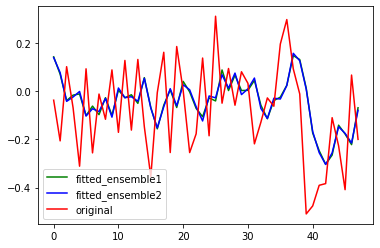

In [38]:
plotTS(original_ts,173940,85,start=2,end=50,fitted_ts1=fitted_ts1,fitted_ts2=fitted_ts2)

In [ ]:
pearsonr(original_ts['sub100206'][:101][:1199],fitted_ts2)

# Lack of Fit Tests for the Ensemble Model

In [7]:
from scipy.stats import chi2

def autocorr(x, t=1):
    return np.corrcoef(np.array([x[:-t], x[t:]]))

# Define Ljung-Box test for lack of fit
def LjungBoxTest(res,df,alpha,h):
    # res: residual sequence
    # df: degree of freedom of the ARMA model
    # alpha: confidence level
    # h: the number of lags to be tested
    
    # null hypothesis: H_0: no significant lack of fit upto lag h
    # alternative hypothesis: H_a: significant lack of fit
    
    # return True if lack of fit
    n = len(res)
 
    # number of terms involved in the computation of Q statistics 
    
    
    # compute Q statistics
    Q= sum(autocorr(res,k)[0][1]**2/(n-k) for k in range(1,12))*n*(n+2)
    # compute critical threshold
    chi2_percentile_point = chi2.ppf(alpha,12-h)
    
    if Q>chi2_percentile_point:
        return True # return True if lack of fit
    else:
        return False
    

#### Load models involved in the ensembling process. We need this information to determine the degrees of freedom in the Box-Ljung Test

In [8]:
file_dir = 'E:/projects/connectome/results/HurstExp_ARMA_results_0_to_5/ensemble_orders_and_weights'
file_names = listdir(file_dir)
h = [None for _ in range(len(file_names))] 
# h[i][j] stores the number of lags needed to be used for the ensemble ARMA models which is essentially the maximum of the sum of
# all involved tuple (p,q)

Computing the degrees of freedom: deg = maximum of the sum of (p,q) (degrees of freedom of each ARMA models)

In [17]:
for file_name in file_names:
    ID_num = file_name[-10:-4]
    subject_ID = 'sub'+ID_num
    
    file = join(file_dir,file_name)
    sub_orders_and_weights = scipy.io.loadmat(file)['ensemble_orders_and_weights']
    sub_h = [None for _ in range(160)]
    for j in range(160):
        # compute degrees of freedom
        sub_h[j] = max(sum(sub_orders_and_weights[j][0][i]) for i in range(len(sub_orders_and_weights[j][0])))
    h[ID_to_row_num[subject_ID]] = sub_h

KeyError: 'ensemble_orders_and_weights'

In [ ]:
file_dir = 'E:/projects/connectome/results/HurstExp_ARMA_results_0_to_5/ensemble_ts'
file_names = listdir(file_dir)

# LB_test[i][j] stores the Ljung-Box test result for region j of subject i
LB_test_res = [None for _ in range(len(file_names))]


for i,file_name in enumerate(file_names):
    ID_num = file_name[-10:-4]
    subject_ID = 'sub'+ID_num
    
    subject_test_res = []
    # compute LB statistics and p-values for each of the 160 regions
    for j in range(160):
        # compute residual of the fitted ensemble model
        residual = original_ts[ID_to_row_num[subject_ID]][:,j] - fitted_ts[ID_to_row_num[subject_ID]][j,:]
        # extract degrees of freedom
        nlags = h[ID_to_row_num[subject_ID]][j]
        lack_of_fit = LjungBoxTest(residual,df,0.95,10)
        if lack_of_fit==True: 
            subject_test_res.append(0)
        else:
            subject_test_res.append(1)
    print('subject {} is done'.format(i,j))
    LB_test_res[ID_to_row_num[subject_ID]] = subject_test_res        

subject 0 is done
subject 1 is done
subject 2 is done
subject 3 is done
subject 4 is done
subject 5 is done
subject 6 is done
subject 7 is done
subject 8 is done
subject 9 is done
subject 10 is done
subject 11 is done
subject 12 is done
subject 13 is done
subject 14 is done
subject 15 is done
subject 16 is done
subject 17 is done
subject 18 is done
subject 19 is done
subject 20 is done
subject 21 is done
subject 22 is done
subject 23 is done
subject 24 is done
subject 25 is done
subject 26 is done
subject 27 is done
subject 28 is done
subject 29 is done
subject 30 is done
subject 31 is done
subject 32 is done
subject 33 is done
subject 34 is done
subject 35 is done
subject 36 is done
subject 37 is done
subject 38 is done
subject 39 is done
subject 40 is done
subject 41 is done
subject 42 is done
subject 43 is done
subject 44 is done
subject 45 is done
subject 46 is done
subject 47 is done
subject 48 is done
subject 49 is done
subject 50 is done
subject 51 is done
subject 52 is done
sub

subject 416 is done
subject 417 is done
subject 418 is done
subject 419 is done
subject 420 is done
subject 421 is done
subject 422 is done
subject 423 is done
subject 424 is done
subject 425 is done
subject 426 is done
subject 427 is done
subject 428 is done
subject 429 is done
subject 430 is done
subject 431 is done
subject 432 is done
subject 433 is done
subject 434 is done
subject 435 is done
subject 436 is done
subject 437 is done
subject 438 is done
subject 439 is done
subject 440 is done
subject 441 is done
subject 442 is done
subject 443 is done
subject 444 is done
subject 445 is done
subject 446 is done
subject 447 is done
subject 448 is done
subject 449 is done
subject 450 is done
subject 451 is done
subject 452 is done
subject 453 is done
subject 454 is done
subject 455 is done
subject 456 is done
subject 457 is done
subject 458 is done
subject 459 is done
subject 460 is done
subject 461 is done
subject 462 is done
subject 463 is done
subject 464 is done
subject 465 is done


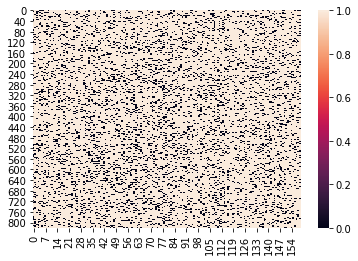

In [302]:
seaborn.heatmap(LB_test_res)
plt.show()

# F tests for Significant Model Improvement 

In [10]:
def Ftest(res1,res2,df1,df2):
    n = len(res1)
    RSS1 = sum(np.array(res1)**2)
    RSS2 = sum(np.array(res2)**2)
    
    critical_val = scipy.stats.f.ppf(0.95,df2-df1,n-df2)
    F_stat = (n-df2)*(RSS1-RSS2)/((df2-df1)*RSS2)
    
    return F_stat>critical_val

In [11]:
file_dir = 'E:/projects/connectome/results/HurstExp_ARMA_results_0_to_5/ensemble_ts'
file_names = listdir(file_dir)

# LB_test[i][j] stores the Ljung-Box test result for region j of subject i
F_test_res = [None for _ in range(len(file_names))]


for i,file_name in enumerate(file_names):
    ID_num = file_name[-10:-4]
    subject_ID = 'sub'+ID_num
    
    subject_test_res = []
    # compute LB statistics and p-values for each of the 160 regions
    for j in range(160):
        # compute residual of the fitted ensemble model
        residual1 = original_ts[ID_to_row_num[subject_ID]][:,j] - fitted_ts1[ID_to_row_num[subject_ID]][j,:]
        residual2 = original_ts[ID_to_row_num[subject_ID]][:,j] - fitted_ts2[ID_to_row_num[subject_ID]][j,:]
        # extract degrees of freedom
        significant_improvement = Ftest(residual1,residual2,8,10)
        if significant_improvement==True: 
            subject_test_res.append(1)
        else:
            subject_test_res.append(0)
    print('subject {} is done'.format(i,j))
    F_test_res[ID_to_row_num[subject_ID]] = subject_test_res  

subject 0 is done
subject 1 is done
subject 2 is done
subject 3 is done
subject 4 is done
subject 5 is done
subject 6 is done
subject 7 is done
subject 8 is done
subject 9 is done
subject 10 is done
subject 11 is done
subject 12 is done
subject 13 is done
subject 14 is done
subject 15 is done
subject 16 is done
subject 17 is done
subject 18 is done
subject 19 is done
subject 20 is done
subject 21 is done
subject 22 is done
subject 23 is done
subject 24 is done
subject 25 is done
subject 26 is done
subject 27 is done
subject 28 is done
subject 29 is done
subject 30 is done
subject 31 is done
subject 32 is done
subject 33 is done
subject 34 is done
subject 35 is done
subject 36 is done
subject 37 is done
subject 38 is done
subject 39 is done
subject 40 is done
subject 41 is done
subject 42 is done
subject 43 is done
subject 44 is done
subject 45 is done
subject 46 is done
subject 47 is done
subject 48 is done
subject 49 is done
subject 50 is done
subject 51 is done
subject 52 is done
sub

subject 416 is done
subject 417 is done
subject 418 is done
subject 419 is done
subject 420 is done
subject 421 is done
subject 422 is done
subject 423 is done
subject 424 is done
subject 425 is done
subject 426 is done
subject 427 is done
subject 428 is done
subject 429 is done
subject 430 is done
subject 431 is done
subject 432 is done
subject 433 is done
subject 434 is done
subject 435 is done
subject 436 is done
subject 437 is done
subject 438 is done
subject 439 is done
subject 440 is done
subject 441 is done
subject 442 is done
subject 443 is done
subject 444 is done
subject 445 is done
subject 446 is done
subject 447 is done
subject 448 is done
subject 449 is done
subject 450 is done
subject 451 is done
subject 452 is done
subject 453 is done
subject 454 is done
subject 455 is done
subject 456 is done
subject 457 is done
subject 458 is done
subject 459 is done
subject 460 is done
subject 461 is done
subject 462 is done
subject 463 is done
subject 464 is done
subject 465 is done


# Improvement by using one more time point

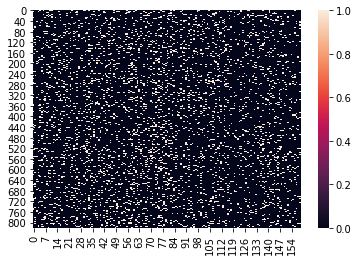

In [12]:
seaborn.heatmap(F_test_res)
plt.show()

In [14]:
reg_improved_total = []
for i in range(160):
    reg_improved_total.append(sum(F_test_res[i]))

# total number of improved subjects in each region

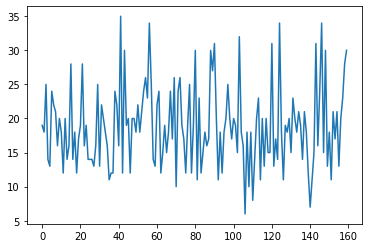

In [16]:
plt.plot(reg_improved_total)
plt.show()